In [72]:
from math import exp, sqrt, pi
import numpy as np
import pandas as pd

k = 3
R = 10
mu = np.linspace(-0.75*R, 0.75*R, k+1)[:-1] + np.random.uniform(0, 1.5*R/k, k)
sigma = R/12 * np.random.uniform(1,2,k)
lamb = np.ones(k) + np.random.dirichlet(0.3 * np.ones(k))
lamb /= lamb.sum()

print(mu,sigma,lamb,sep='\n')
def p(x):
    pdfs = [lamb[i] * exp(-0.5 * (x - mu[i])**2 / sigma[i]**2) / sqrt(2*pi) / sigma[i] for i in range(k)]
    return sum(pdfs)

[-6.99798647 -1.81850966  7.43711708]
[1.35493142 1.57388003 1.57265094]
[0.25018866 0.45920976 0.29060158]


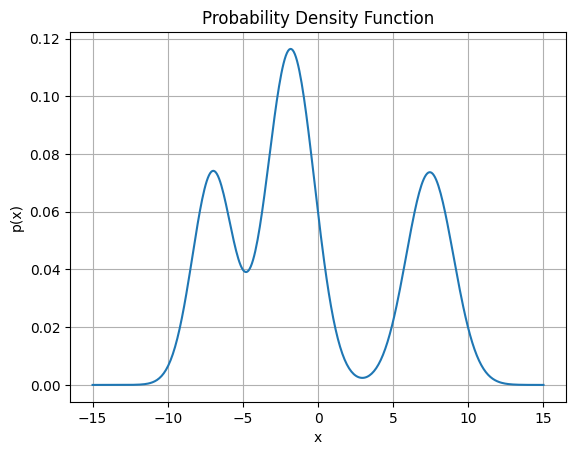

In [73]:
import matplotlib.pyplot as plt

x_grid = np.linspace(-1.5*R, 1.5*R, 400)
y = [p(val) for val in x_grid]

plt.plot(x_grid, y)
plt.title('Probability Density Function')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.grid(True)
plt.show()

The above pdf is a pdf of mixture of Gaussian model.

Consider a general pdf, like MoG density with unknown paramters, how to sample from it? We always assume we have random generator of uniform distributions. 

### Traditional Methods

If cdf has an explicit inverse, we can sample by composing inverse cdf. 

E.g. sampling exponential distributions. cdf $F(x) = 1- e^{-x}$, inverse cdf $G(u) = -\log(1-u)$


<Axes: >

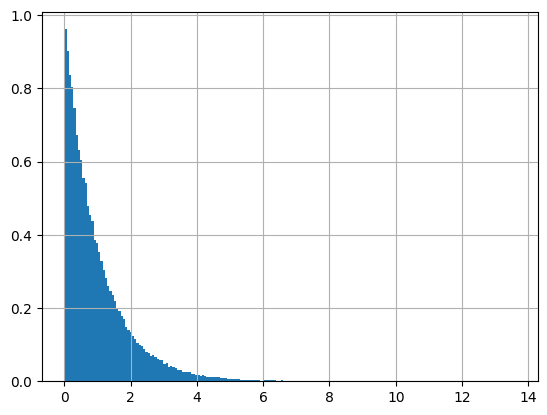

In [74]:
x = np.random.rand(100000)
y = -np.log(1-x)
pd.Series(y).hist(bins=200, density=True)

Let's assume the pdf p(x) is bounded above by M. Then we can use another distribution q that we know how to sample ot cover p. I.e. Find a M such that $p(x) \leq Mq(x)$ for all x. Then we can sample q instead, and for each sample, we adjust the sample by sample another a uniform distribution, comparing it with $p/Mq$, and decide to keep it or not.  This method requires we know the (range of) the maximal of $p$.


This methods works well for sampling from analytically tractable distributions, say sampling normal from exponential.

  0%|          | 0/100000 [00:00<?, ?it/s]

Total accept_rate: 76.09


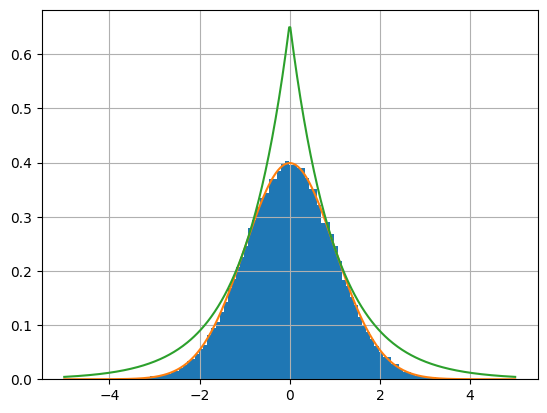

In [ ]:
# example to sample normal using exponential distribution
N_samples = 100000
samples = []

x_grid = np.linspace(-5, 5, 400)
M = max([2*q(val,1)/exp(-val) for val in np.abs(x_grid)])
for i in tqdm(range(N_samples)):
    x = np.random.exponential(1)
    sign = np.random.choice([-1,1])
    u = np.random.uniform()
    if u < 2*q(x,1)/(exp(-x)*M):
        samples.append(x * sign)

print(f"Total accept_rate: {100* len(samples)/N_samples:.2f}")
pd.Series(samples).hist(bins=100, density=True)
plt.plot(x_grid, [q(val,1) for val in x_grid])
plt.plot(x_grid, [exp(-val)/2 * M for val in np.abs(x_grid)])


The issue for this method is that 
- requires the computation of $M$, sometimes we don't have a good bound of $p$
- many sample wasted in the rejection part, becomes an issue when dimension increases : sampling efficiency multiplies

M: 2.9686320645896807


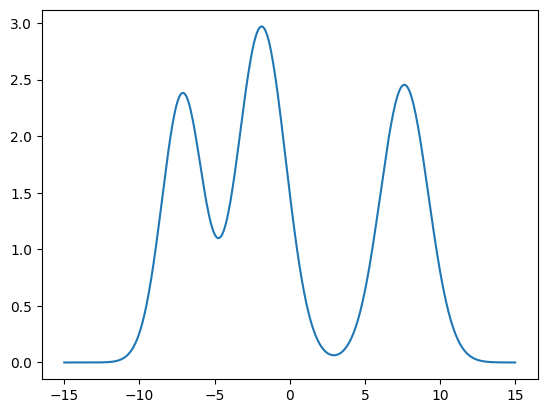

In [77]:
def q(x,s):
    return 1/( 2 * pi) ** 0.5/s * exp( - x ** 2 / 2 / s**2)

x_grid = np.linspace(-1.5*R, 1.5*R, 400)
y = [p(val) for val in x_grid]

s = 10
M = max([p(val) / q(val,s) for val in x_grid])
plt.plot(x_grid, [p(val)/ q(val,s) for val in x_grid], label='M*q(x)')
print('M:', M)

  0%|          | 0/100000 [00:00<?, ?it/s]

Total accept_rate: 33.62


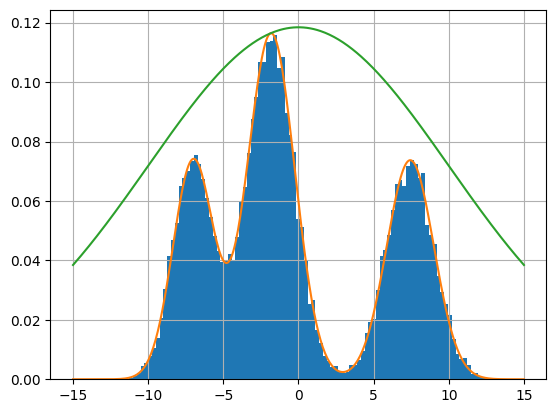

In [79]:
from tqdm.notebook import tqdm
import pandas as pd

N_samples = 100000
samples = []
for i in tqdm(range(N_samples)):
    x = s*np.random.randn()
    u = np.random.uniform()
    if u < p(x)/(q(x,s) * M):
        samples.append(x)
print(f"Total accept_rate: {100* len(samples)/N_samples:.2f}")
pd.Series(samples).hist(bins=100, density=True)
plt.plot(x_grid, y)
plt.plot(x_grid, [M*q(val,s) for val in x_grid], label='q(x)')

### MCMC